In [1]:
from __future__ import absolute_import, division, print_function
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
parasitized_contrast = os.listdir('./Parasitized_enlarge/contrast/') 
uninfected_contrast = os.listdir('./Uninfected_enlarge/contrast/') 
data = []
labels = []


In [3]:
for positive_data in parasitized_contrast:
    if positive_data == "Thumbs.db":
        continue
    image = Image.open("./Parasitized_enlarge/contrast/" + positive_data)
    image = image.resize((64, 64))
    rotated30 = image.rotate(30)
    rotated60 = image.rotate(60)
    rotated90 = image.rotate(90)

    data.append(np.array(image))
    data.append(np.array(rotated30))
    data.append(np.array(rotated60))
    data.append(np.array(rotated90))
    labels.append(1)
    labels.append(1)
    labels.append(1)
    labels.append(1)

for negative_data in uninfected_contrast:
    if negative_data == "Thumbs.db":
        continue
    image = Image.open("./Uninfected_enlarge/contrast/" + negative_data)
    image = image.resize((64, 64))
    rotated30 = image.rotate(30)
    rotated60 = image.rotate(60)
    rotated90 = image.rotate(90)
    
    data.append(np.array(image))
    data.append(np.array(rotated30))
    data.append(np.array(rotated60))
    data.append(np.array(rotated90))
    labels.append(0)
    labels.append(0)
    labels.append(0)
    labels.append(0)

In [4]:
Data = np.array(data)
Labels = np.array(labels)

np.save('Data' , Data)
np.save('Labels' , Labels)
print('Data : {} | labels : {}'.format(Data.shape , Labels.shape))

Data : (110232, 64, 64, 3) | labels : (110232,)


In [5]:
from sklearn.utils import shuffle
Data, Labels = shuffle(Data, Labels)

In [6]:
Data = Data.astype(np.float32)
Data = Data / 255
Labels = Labels.astype(np.int32)
from sklearn.model_selection import train_test_split
ntrain = int(len(Data)*0.8)
X_test = Data[ntrain:]
y_test = Labels[ntrain:]
X_train, X_val, y_train, Y_val = train_test_split(Data[0:ntrain], Labels[0:ntrain], test_size=0.2, random_state = 40)

In [15]:
from keras.applications.vgg16 import VGG16
from keras.models import Sequential, Model
from keras.optimizers import RMSprop, Adam, SGD
from keras.layers import Dense, Dropout, Activation, Flatten, Input
# def vgg16_model(input_shape= (64,64,3)):
#     vgg16 = VGG16(include_top=False, weights='imagenet',input_shape=input_shape)
    
#     for layer in vgg16.layers:
#         layer.trainable = False
#     last = vgg16.output
#     x = Flatten()(last)
#     x = Dense(256, activation='relu')(x)
#     x = Dropout(0.5)(x)
#     x = Dense(1, activation='sigmoid')(x)
    
#     model = Model(inputs=vgg16.input, outputs=x)
    
#     return model
base_model = VGG16(include_top=False, weights='imagenet',input_shape=(64,64,3))
base_model.trainable = False  #Tells that all the weights are to be trained

In [17]:
from keras import models
model= models.Sequential()           #Creating the sequntial model
model.add(base_model)                #Adding the imagenet model
model.add(Flatten())                                #
model.add(Dense(512,activation="relu"))             #
model.add(Dropout(0.5))                             #
model.add(Dense(1,activation="sigmoid"))  #
model.summary()
model.compile(loss='binary_crossentropy',optimizer = Adam(0.0001), metrics = ['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 513       
Total params: 15,764,289
Trainable params: 1,049,601
Non-trainable params: 14,714,688
_________________________________________________________________


In [18]:
history = model.fit(X_train,y_train, validation_data=(X_val, Y_val),epochs=30,batch_size=100,verbose=True)
score = model.evaluate(X_test, y_test, verbose=0)

Train on 70548 samples, validate on 17637 samples
Epoch 1/30
70548/70548 [==============================] - 27s 383us/step - loss: 0.2540 - acc: 0.8962 - val_loss: 0.1937 - val_acc: 0.9259
Epoch 2/30
70548/70548 [==============================] - 27s 382us/step - loss: 0.1891 - acc: 0.9284 - val_loss: 0.1765 - val_acc: 0.9312
Epoch 3/30
70548/70548 [==============================] - 27s 383us/step - loss: 0.1756 - acc: 0.9338 - val_loss: 0.1672 - val_acc: 0.9379
Epoch 4/30
70548/70548 [==============================] - 27s 380us/step - loss: 0.1673 - acc: 0.9370 - val_loss: 0.1619 - val_acc: 0.9390
Epoch 5/30
70548/70548 [==============================] - 27s 383us/step - loss: 0.1616 - acc: 0.9394 - val_loss: 0.1595 - val_acc: 0.9401
Epoch 6/30
70548/70548 [==============================] - 27s 376us/step - loss: 0.1569 - acc: 0.9420 - val_loss: 0.1570 - val_acc: 0.9405
Epoch 7/30
70548/70548 [==============================] - 27s 381us/step - loss: 0.1545 - acc: 0.9422 - val_loss: 0.

In [19]:
print("Test loss: " + str(score[0]))
print("Test accuracy: " + str(score[1]))

Test loss: 0.12557007188370542
Test accuracy: 0.9534630561575693


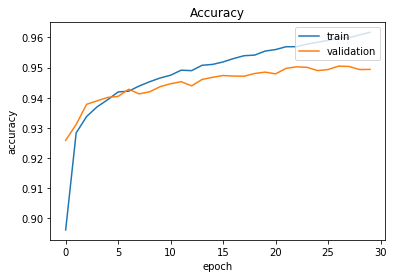

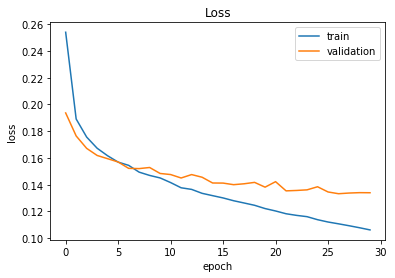

In [20]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper right')
plt.show()

In [22]:
y_pred = model.predict_classes(X_test)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred).ravel() # tn, fp, fn, tp

array([10497,   556,   470, 10524])